This notebook uses several different models to predict popularity using likes/views as popularity calculation. Additionally, this notebook uses topics as a predictor.

In [17]:
import numpy as np
import pandas as pd
import ast
from collections import OrderedDict
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv("../data/data_sentiment_analysis.csv")
#df = df[0:20]
# print(len(df))
df = df.dropna()
# print(len(df))
df.describe()

,Unnamed: 0.1,Unnamed: 0,_id,duration,likes,views,tb_score,vd_score
count,4983.000000,4983.000000,4983.000000,4983.000000,4.983000e+03,4.983000e+03,4983.000000,4983.000000
mean,2732.942003,2732.942003,24648.154525,686.436885,7.051936e+04,2.370903e+06,0.108438,0.741949
std,1648.784090,1648.784090,29866.800844,385.181603,1.134161e+05,3.833013e+06,0.062795,0.627445
min,0.000000,0.000000,1.000000,60.000000,1.260000e+02,4.209000e+03,-0.259643,-0.999900
25%,1290.500000,1290.500000,1515.500000,339.000000,2.700000e+04,9.297965e+05,0.070541,0.980050
50%,2654.000000,2654.000000,2854.000000,683.000000,4.500000e+04,1.517960e+06,0.108392,0.997700
75%,4176.500000,4176.500000,48651.500000,930.000000,6.900000e+04,2.323995e+06,0.146548,0.999400
max,5630.000000,5630.000000,95714.000000,4154.000000,2.200000e+06,7.338914e+07,0.594444,1.000000


In [3]:
# create popularity column by dividing likes and views
df['likes_log'] = np.log(df['likes'])
df['popularity'] = (df['likes']/df['views']) * 100

# Let's view the dataset again
df.head()
df['topics_list'] = df['topics_list'].apply(ast.literal_eval)
# print(type(df['topics_list'][0]))
#print(type(df['topics'][0]))

In [5]:
from collections import Counter

topics = [thing for inner_list in df['topics_list'].tolist() for thing in inner_list]
count_topics = Counter(topics)
count_dict = dict(count_topics)

# print(count_dict)

# topics with less than 100 instances
under_100 = {k:v for (k,v) in count_dict.items() if v < 100}

In [6]:
mlb = MultiLabelBinarizer()
mlb.fit_transform(df['topics_list'])
print(mlb.classes_)

['3D printing' 'AI' 'AIDS' 'Africa' "Alzheimer's" 'Antarctica'
 'Anthropocene' 'Asia' 'Audacious Project' 'Autism spectrum disorder'
 'Best of the Web' 'Big Bang' 'Brazil' 'Buddhism' 'CRISPR' 'Christianity'
 'Countdown' 'DNA' 'Egypt' 'Europe' 'Hinduism' 'Humanities' 'Internet'
 'Islam' 'Judaism' 'LGBTQIA+' 'Life' 'Mars' 'Middle East' 'Mission Blue'
 'Moon' 'NASA' 'NFTs' 'PTSD' 'Planets' 'Slavery' 'South America'
 'String theory' 'Sun' 'Surgery' 'TED Books' 'TED Connects' 'TED Fellows'
 'TED Membership' 'TED Prize' 'TED Residency' 'TED en Español' 'TED-Ed'
 'TEDMED' 'TEDx' 'Transgender' 'UX design' 'United States' 'Vaccines'
 'activism' 'addiction' 'aging' 'agriculture' 'algorithm' 'aliens'
 'ancient world' 'animals' 'animation' 'anthropology' 'archaeology'
 'architecture' 'art' 'asteroid' 'astrobiology' 'astronomy' 'atheism'
 'augmented reality' 'bacteria' 'beauty' 'bees' 'behavioral economics'
 'biodiversity' 'bioethics' 'biology' 'biomimicry' 'bionics' 'biosphere'
 'biotech' 'birds' 

In [7]:
# one hot encode the topics in the topics list
topics_encoded = pd.DataFrame(mlb.fit_transform(df['topics_list']), columns=mlb.classes_, index=df.index)
df_encoded = pd.concat([df, topics_encoded], axis=1).drop('topics_list', axis=1)
df_encoded

,Unnamed: 0.1,Unnamed: 0,_id,duration,likes,speakers,subtitle_languages,summary,topics,title,...,water,weather,wind energy,women,women in business,work,work-life balance,worklife,writing,youth
0,0,0,21,992,17000,"[{'name': 'Mena Trott', 'occupation': 'Blogger...","[{'name': 'English', 'code': 'en'}, {'name': '...","The founding mother of the blog revolution, Mo...","[{'id': '4', 'name': 'culture'}, {'id': '13', ...",Meet the founder of the blog revolution,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,957,110000,"[{'name': 'Al Gore', 'occupation': 'Climate ad...","[{'name': 'Greek', 'code': 'el'}, {'name': 'Gu...",With the same humor and humanity he exuded in ...,"[{'id': '3', 'name': 'climate change'}, {'id':...",Averting the climate crisis,...,0,0,0,0,0,0,0,0,0,0
2,2,2,7,1266,60000,"[{'name': 'David Pogue', 'occupation': 'Techno...","[{'name': 'Greek', 'code': 'el'}, {'name': 'En...",New York Times columnist David Pogue takes aim...,"[{'id': '10', 'name': 'technology'}, {'id': '3...",Simplicity sells,...,0,0,0,0,0,0,0,0,0,0
3,3,3,47,1126,80000,"[{'name': 'David Deutsch', 'occupation': 'Phys...","[{'name': 'Greek', 'code': 'el'}, {'name': 'En...",Legendary scientist David Deutsch puts theoret...,"[{'id': '3', 'name': 'climate change'}, {'id':...",Chemical scum that dream of distant quasars,...,0,0,0,0,0,0,0,0,0,0
4,4,4,55,1524,14000,"[{'name': 'Jehane Noujaim', 'occupation': 'Fil...","[{'name': 'English', 'code': 'en'}, {'name': '...",Jehane Noujaim unveils her 2006 TED Prize wish...,"[{'id': '4', 'name': 'culture'}, {'id': '6', '...",My wish: A global day of film,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5626,5626,5626,95714,278,5800,"[{'name': 'Lyla Latif', 'occupation': 'Educato...","[{'name': 'English', 'code': 'en'}, {'name': '...","In 2020, Mali produced over 71 tons of gold— a...","[{'id': '18', 'name': 'business'}, {'id': '19'...",The true cost of gold,...,0,0,0,0,0,0,0,0,0,0
5627,5627,5627,95710,940,10000,"[{'name': 'Trish Millines Dziko', 'occupation'...","[{'name': 'English', 'code': 'en'}, {'name': '...","Forget home economics and standardized tests, ...","[{'id': '52', 'name': 'education'}, {'id': '53...",How schools can nurture every student's genius,...,0,0,0,0,0,0,0,0,0,1
5628,5628,5628,95451,1048,12000,"[{'name': 'David Wengrow', 'occupation': 'Arch...","[{'name': 'English', 'code': 'en'}, {'name': '...",What if the commonly accepted narratives about...,"[{'id': '4', 'name': 'culture'}, {'id': '81', ...",A new understanding of human history and the r...,...,0,0,0,0,0,0,0,0,0,0
5629,5629,5629,95708,651,7200,"[{'name': 'Dan Widmaier', 'occupation': 'Bioma...","[{'name': 'English', 'code': 'en'}]",Your closet is likely full of all kinds of mat...,"[{'id': '5', 'name': 'environment'}, {'id': '8...",The future of fashion -- made from mushrooms,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# include this line if you want to get rid of the topics with too few instances

df_encoded = df_encoded.drop(columns=under_100.keys())

KeyError: '[\'software\', \'transportation\', \'renewable energy\', \'UX design\', \'film\', \'TED Prize\', \'cognitive science\', \'love\', \'theater\', \'philanthropy\', \'Christianity\', \'corruption\', \'military\', \'poverty\', \'international development\', \'investing\', \'dance\', \'parenting\', \'teaching\', \'atheism\', \'comedy\', \'natural disaster\', \'statistics\', \'demo\', \'Asia\', \'consciousness\', \'library\', \'youth\', \'finance\', \'biotech\', \'aging\', \'industrial design\', \'DNA\', \'product design\', \'ebola\', \'drugs\', \'pollution\', \'astronomy\', \'consumerism\', \'marketing\', \'cancer\', \'robots\', \'flight\', \'rocket science\', \'poetry\', \'urban planning\', \'maps\', \'success\', \'genetics\', \'time\', \'biodiversity\', \'ecology\', \'code\', \'primates\', \'illusion\', \'Brazil\', \'AIDS\', \'insects\', \'sports\', \'travel\', \'interview\', \'indigenous peoples\', \'typography\', \'graphic design\', \'work-life balance\', \'anthropology\', \'biomimicry\', \'fish\', \'marine biology\', \'china\', \'memory\', \'spoken word\', \'museums\', \'water\', \'AI\', \'virtual reality\', \'electricity\', \'death\', \'literature\', \'paleontology\', \'women in business\', \'Buddhism\', \'sociology\', \'Moon\', \'Planets\', \'books\', \'prosthetics\', \'bioethics\', \'gaming\', \'terrorism\', \'mindfulness\', \'emotions\', \'South America\', \'String theory\', \'magic\', \'depression\', \'suicide\', \'compassion\', \'empathy\', \'drones\', \'solar energy\', \'solar system\', \'asteroid\', \'Best of the Web\', \'telescopes\', \'ancient world\', \'bees\', \'plants\', \'gardening\', \'infrastructure\', \'toys\', \'cyber security\', \'heart\', \'dinosaurs\', \'archaeology\', \'beauty\', \'plastic\', \'sex\', \'conducting\', \'Vaccines\', \'Big Bang\', \'quantum\', \'fungi\', \'bacteria\', \'microbiology\', \'trees\', \'astrobiology\', \'aliens\', \'personality\', \'dark matter\', \'nanotechnology\', \'television\', \'geology\', \'ethics\', \'public speaking\', \'crime\', \'prison\', \'smell\', \'Mars\', \'social media\', \'fashion\', \'goals\', \'curiosity\', "Alzheimer\'s", \'3D printing\', \'shopping\', \'chemistry\', \'fear\', \'body language\', \'bionics\', \'virus\', \'birds\', \'wind energy\', \'productivity\', \'coral reefs\', \'natural resources\', \'agriculture\', \'india\', \'money\', \'Antarctica\', \'Anthropocene\', \'Europe\', \'sight\', \'Sun\', \'homelessness\', \'weather\', \'rivers\', \'Slavery\', \'sexual violence\', \'Egypt\', \'feminism\', \'TEDMED\', \'Autism spectrum disorder\', \'science fiction\', \'botany\', \'Mission Blue\', \'friendship\', \'nuclear energy\', \'fossil fuels\', \'Middle East\', \'surveillance\', \'Islam\', \'sound\', \'PTSD\', \'manufacturing\', \'bullying\', \'trust\', \'vulnerability\', \'sleep\', \'Surgery\', \'deextinction\', \'blindness\', \'glaciers\', \'driverless cars\', \'LGBTQIA+\', \'public space\', \'encryption\', \'protest\', \'international relations\', \'behavioral economics\', \'medical imaging\', \'pregnancy\', \'synthetic biology\', \'disability\', \'hearing\', \'justice system\', \'algorithm\', \'conservation\', \'exercise\', \'immigration\', \'diversity\', \'online privacy\', \'machine learning\', \'augmented reality\', \'painting\', \'forensics\', \'grammar\', \'discovery\', \'pandemic\', \'meditation\', \'Transgender\', \'neurology\', \'blockchain\', \'cryptocurrency\', \'farming\', \'addiction\', \'Judaism\', \'Hinduism\', \'TED Books\', \'refugees\', \'street art\', \'TED en Español\', \'resources\', \'CRISPR\', \'capitalism\', \'Audacious Project\', \'TED Residency\', \'biosphere\', \'inclusion\', \'human rights\', \'coronavirus\', \'TED Connects\', \'Humanities\', \'crowdsourcing\', \'NASA\', \'microbes\', \'Life\', \'pain\', \'TED Membership\', \'metaverse\', \'NFTs\', \'worklife\', \'veganism\'] not found in axis'

In [ ]:
# view columns
df_encoded.columns.tolist()

['Unnamed: 0.1',
 'Unnamed: 0',
 '_id',
 'duration',
 'likes',
 'speakers',
 'subtitle_languages',
 'summary',
 'topics',
 'title',
 'transcript',
 'views',
 'recorded_date',
 'published_date',
 'speakers_list',
 'sl_list',
 'processed_transcript',
 'tb_score',
 'vd_score',
 'likes_log',
 'popularity',
 'Africa',
 'Countdown',
 'Internet',
 'TED Fellows',
 'TED-Ed',
 'TEDx',
 'United States',
 'activism',
 'animals',
 'animation',
 'architecture',
 'art',
 'biology',
 'brain',
 'business',
 'cities',
 'climate change',
 'collaboration',
 'communication',
 'community',
 'computers',
 'creativity',
 'culture',
 'data',
 'decision-making',
 'democracy',
 'design',
 'disease',
 'economics',
 'education',
 'energy',
 'engineering',
 'entertainment',
 'entrepreneur',
 'environment',
 'equality',
 'evolution',
 'exploration',
 'family',
 'food',
 'future',
 'gender',
 'global issues',
 'government',
 'happiness',
 'health',
 'health care',
 'history',
 'human body',
 'humanity',
 'humor',
 'i

In [20]:
# eliminate columns from dataset that we do not need for model
X = df_encoded.drop(['Unnamed: 0.1', 'Unnamed: 0', '_id', 'likes', 'published_date', 'recorded_date', 'speakers', 'subtitle_languages', 'summary', 'title', 'topics', 'transcript','views', 'speakers_list','sl_list','processed_transcript', 'popularity', 'likes_log'], axis=1)
# assign the y variable to be popularity
y = df_encoded['likes_log']

In [21]:
# split data into testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
X.head()

,duration,tb_score,vd_score,Africa,Countdown,Internet,TED Fellows,TED-Ed,TEDx,United States,...,storytelling,sustainability,technology,universe,violence,visualizations,war,women,work,writing
0,992,0.133855,0.9996,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,957,0.131762,0.9997,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
2,1266,0.155493,0.9999,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1126,0.066814,0.9990,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,1524,0.127882,0.9995,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [23]:
# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Linear Regression

In [24]:
from sklearn import linear_model

In [25]:
# fit model using scaled training data
reg = linear_model.LinearRegression().fit(X_train_scaled, y_train)
reg.score(X_train_scaled, y_train)

0.14024677553022324

In [26]:
# predict y value and calculate mse
y_pred_linear = reg.predict(X_test_scaled)
mse_linear = np.mean((y_pred_linear - y_test) ** 2)
mse_linear

0.8875797307140667

In [27]:
print(mean_squared_error(y_test, y_pred_linear))
print(r2_score(y_test, y_pred_linear))

0.8875797307140667
0.09192294015401092


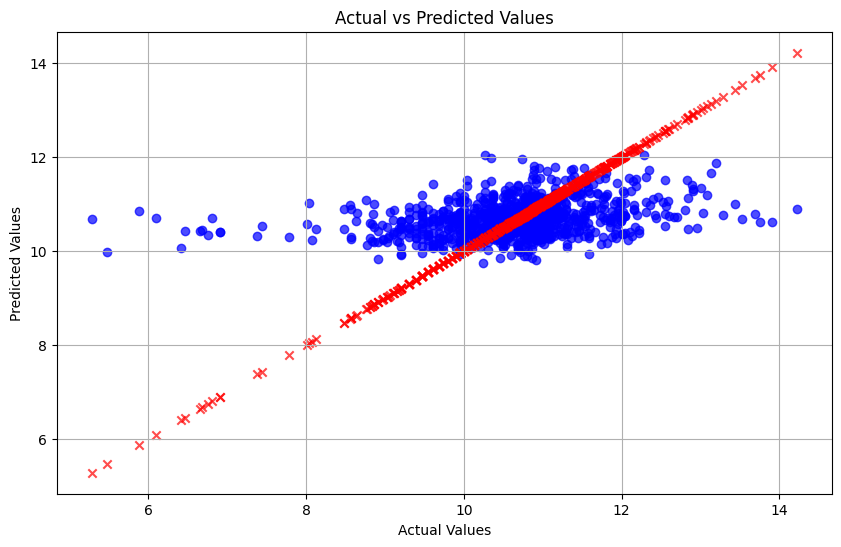

In [28]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_linear  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

Lasso Regression

In [29]:
reg = linear_model.Lasso(alpha=1)
reg.fit(X_train_scaled, y_train)

Lasso(alpha=1)

In [30]:
# predict popularity using lasso regression
y_pred_lasso = reg.predict(X_test_scaled)
mse_lasso = np.mean((y_pred_lasso - y_test) ** 2)
mse_lasso

0.980582355210467

In [31]:
print(mean_squared_error(y_test, y_pred_lasso))
print(r2_score(y_test, y_pred_lasso))

0.980582355210467
-0.0032274411449266793


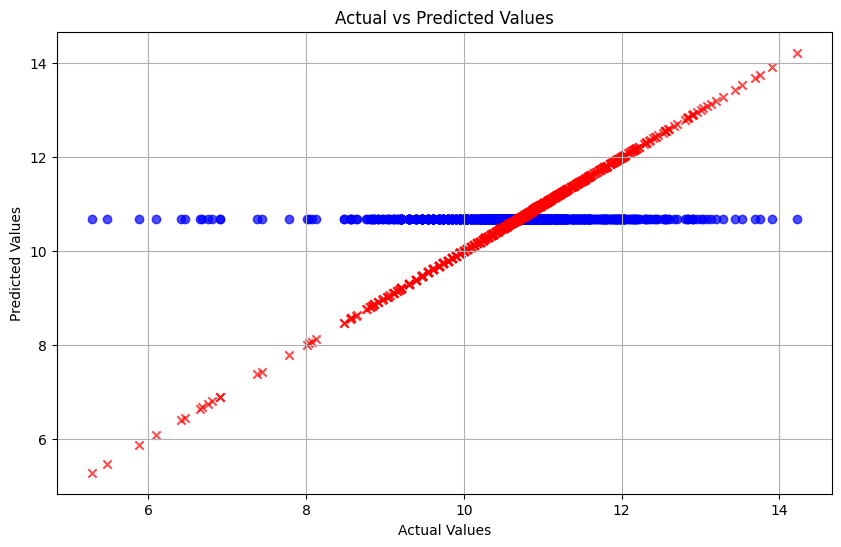

In [32]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_lasso  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

Support Vector Regression

In [33]:
svr_linear = SVR(kernel='linear', C=1.0, epsilon=0.1)
svr_rbf = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_poly = SVR(kernel='poly', degree=3, C=1.0, epsilon=0.1)
svr_sigmoid = SVR(kernel='sigmoid', C=1.0, epsilon=0.1)

In [34]:
svr_linear.fit(X_train_scaled, y_train)
svr_rbf.fit(X_train_scaled, y_train)
svr_poly.fit(X_train_scaled, y_train)
svr_sigmoid.fit(X_train_scaled, y_train)

SVR(kernel='sigmoid')

In [35]:
y_pred_svr_linear = svr_linear.predict(X_test_scaled)
y_pred_rbf = svr_rbf.predict(X_test_scaled)
y_pred_poly = svr_poly.predict(X_test_scaled)
y_pred_sigmoid = svr_sigmoid.predict(X_test_scaled)

In [36]:
mse_linear = np.mean((y_pred_svr_linear - y_test) ** 2)
mse_linear

0.8833033341063165

In [37]:
print(r2_score(y_test, y_pred_svr_linear))
print(r2_score(y_test, y_pred_rbf))
print(r2_score(y_test, y_pred_poly))
print(r2_score(y_test, y_pred_sigmoid))

0.09629809375872089
0.1276552990007147
0.05297063322136342
-3.7613152720799654


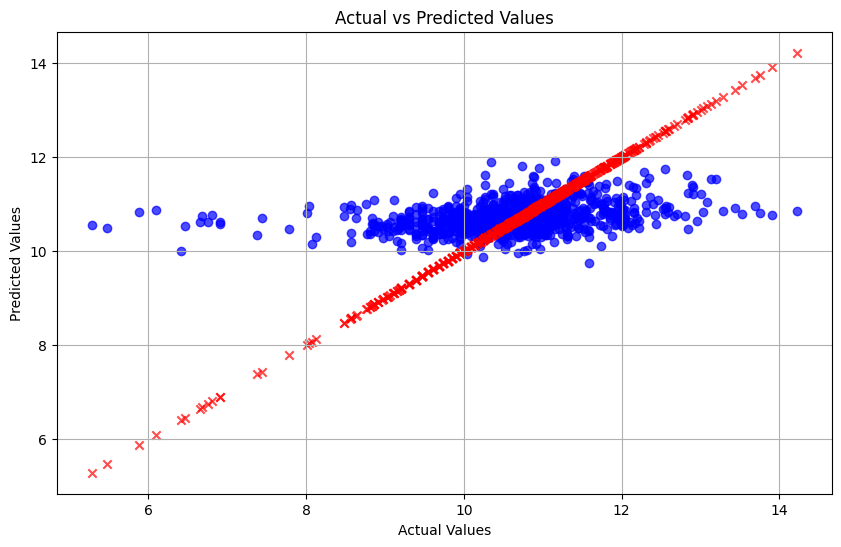

In [38]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_svr_linear  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [39]:
mse_rbf = np.mean((y_pred_rbf - y_test) ** 2)
mse_rbf

0.8526539310816933

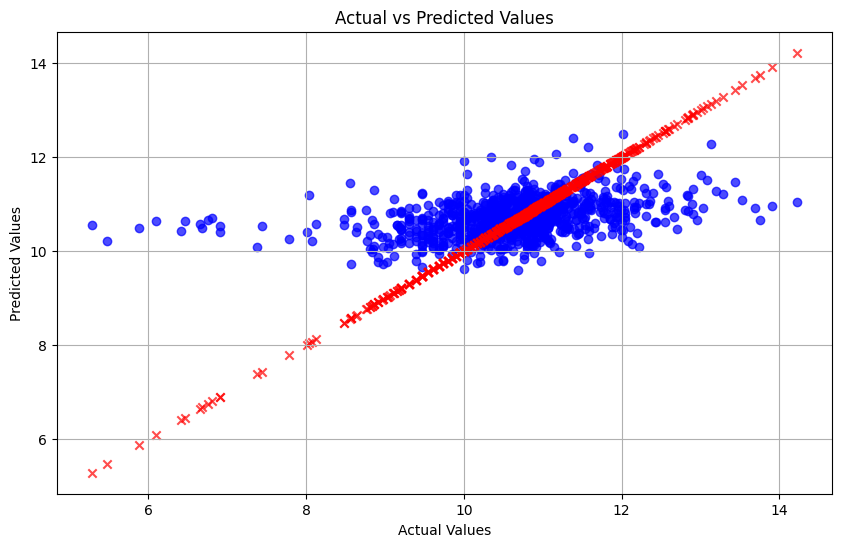

In [40]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_rbf  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [41]:
mse_poly = np.mean((y_pred_poly - y_test) ** 2)
mse_poly

0.9256527970062981

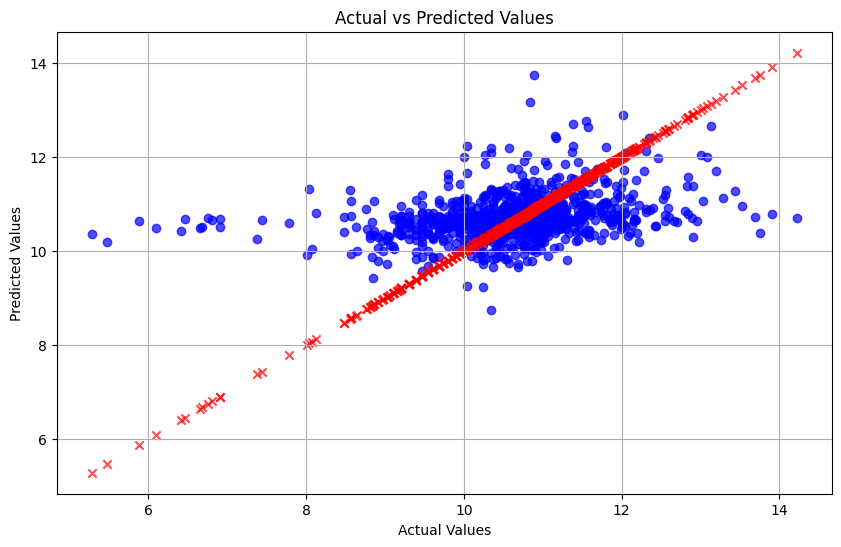

In [42]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_poly  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [43]:
mse_sigmoid = np.mean((y_pred_sigmoid - y_test) ** 2)
mse_sigmoid

4.65384174307217

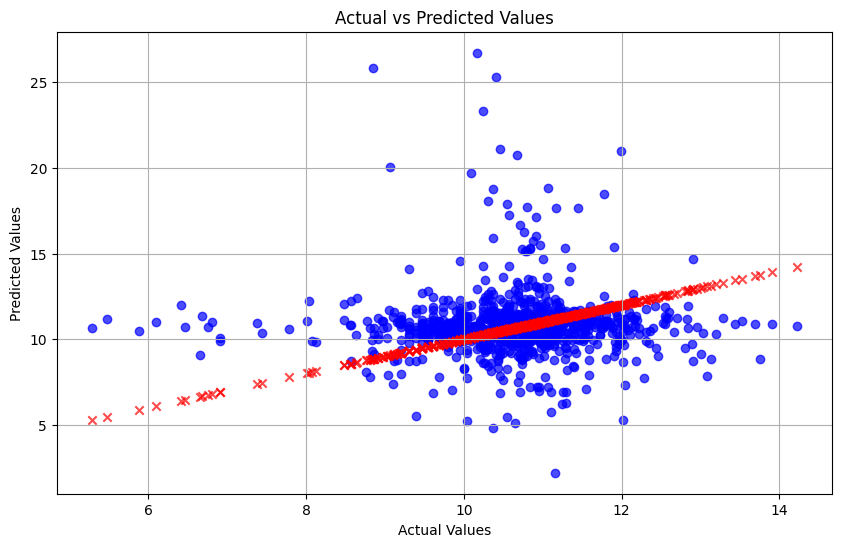

In [44]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_sigmoid  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [45]:
print(r2_score(y_test, y_pred_linear))
print(r2_score(y_test, y_pred_lasso))
print(r2_score(y_test, y_pred_svr_linear))
print(r2_score(y_test, y_pred_rbf))
print(r2_score(y_test, y_pred_poly))
print(r2_score(y_test, y_pred_sigmoid))

0.09192294015401092
-0.0032274411449266793
0.09629809375872089
0.1276552990007147
0.05297063322136342
-3.7613152720799654
